### Random Selection Experiment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.stats import t
from scipy.stats import uniform
from scipy.stats import ttest_1samp # library for p-value estimation
import ruptures as rpt # library for change point detection
%matplotlib inline
import matplotlib.patheffects as mpe
%run ./Experiment_Functions.ipynb
# load functions for the creation of the different distributions

In [2]:
# for visulaization purposes
def replace_outlier(val, mean, std, const=5):
    if val > mean + const*std:
        return mean + const*std 
    elif val < mean - const*std:
        return mean - const*std
    return val

In [3]:
# define arms
def quick_sort(df):
    sorted_df = df.sort_values(kind="quicksort")
    return sorted_df
def merge_sort(df):
    sorted_df = df.sort_values(kind="mergesort")
    return sorted_df
def heap_sort(df):
    sorted_df = df.sort_values(kind="heapsort")
    return sorted_df

In [4]:
choices = [quick_sort,merge_sort,heap_sort]
choices_names = ["quick_sort","merge_sort","heap_sort"]
dist_types = ["Uniform","Normal","Uniform_Sorted","Uniform_Reverse_Sorted","Uniform_Nearly_Sorted","Zipf", "Dates", "Strings", "Discrete_Uniform", "Discrete_Binomial", "Poisson"]

In [5]:
def plot_dataset(data):
    plt.figure(figsize=(16,6))
    plt.plot(data, label="CR863")
    plt.legend(fontsize=24, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel("Value",fontsize=26)
    plt.xlabel("Number of Observation",fontsize=26)
    plt.xticks(fontsize=26)
    plt.yticks(fontsize=26)

In [6]:
def plot_rewards_distribution_together(arm_rewards, bins = 20):
    for key in arm_rewards:    
        arm_rewards[key] = [i * (-1) for i in arm_rewards[key]]
    #arm_rewards["quick_sort"] = arm_rewards["quick_sort"]*(-1)
    #arm_rewards["merge_sort"] = arm_rewards["merge_sort"]*(-1)
    #arm_rewards["heap_sort"] = arm_rewards["heap_sort"]*(-1)
    plt.figure(figsize=(16,6))
    _, bin_edges_qs = np.histogram(arm_rewards["quick_sort"], density=True)
    _, bin_edges_ms = np.histogram(arm_rewards["merge_sort"], density=True)
    _, bin_edges_hs = np.histogram(arm_rewards["heap_sort"], density=True)
    plt.hist(arm_rewards["quick_sort"], bins=bin_edges_qs, alpha = 0.5, label='quick sort')
    plt.hist(arm_rewards["merge_sort"], bins=bin_edges_ms, alpha = 0.5, label='merge sort')
    plt.hist(arm_rewards["heap_sort"], bins=bin_edges_hs, alpha = 0.5, label='heap sort')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5) ,fontsize=26)
    plt.title("Distribution of runtimes during experiment",fontsize=26)
    plt.ylabel("Frequency",fontsize=26)
    plt.xlabel("Runtime in seconds",fontsize=26)
    plt.xticks(fontsize=26)
    plt.yticks(fontsize=26)

In [7]:
def plot_history(rewards,cum_rewards,chosen_arms):
    print("Arm Counts", chosen_arms)
    fig = plt.figure(figsize=[16,6])
    ax2 = fig.add_subplot(121)
    ax2.plot(cum_rewards, label="avg rewards")
    ax2.set_title("Cummulative Rewards",fontsize=18)
    ax2.set_ylabel('Reward (multiplied by -1)',fontsize=16)
    ax2.set_xlabel('Iteration',fontsize=16)
    plt.setp(ax2.get_xticklabels(), fontsize=14)
    plt.setp(ax2.get_yticklabels(), fontsize=14)
    labels = list(chosen_arms.keys())
    ax3 = fig.add_subplot(122)
    ax3.bar(chosen_arms.keys(), chosen_arms.values())
    ax3.set_title("Chosen Actions",fontsize=18)
    ax3.set_ylabel('Frequency',fontsize=16)
    ax3.set_xlabel('Action',fontsize=16)
    plt.setp(ax3.get_xticklabels(), fontsize=14)
    plt.setp(ax3.get_yticklabels(), fontsize=14)

In [8]:
def plot_history_iterations(history):
    df = pd.DataFrame.from_records(history,columns=["Iteration","Reward","Algorithm"])
    mean = df["Reward"].mean()
    std_dev = df["Reward"].std()
    df["Reward"] = df["Reward"].map(lambda x: replace_outlier(x, mean, std_dev))
    df["Reward"] = df["Reward"]*(-1)
    groups = df.groupby('Algorithm')
    # Plot
    dict_colors = {"quick_sort":'#1f77b4', "merge_sort":'#ff7f0e', "heap_sort":'#2ca02c'}
    plt.figure(figsize=(16,6))
    for name, group in groups:
        plt.plot(group.Iteration, group.Reward, marker='o', linestyle='', ms=10, alpha = 0.5, label=name, color=dict_colors[name])
    plt.legend(fontsize=26, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("Algorithm choices during experiment",fontsize=26)
    plt.ylabel("Runtime in seconds",fontsize=26)
    plt.xlabel("Iteration",fontsize=26)
    plt.xticks(fontsize=26)
    plt.yticks(fontsize=26)

In [9]:
# help function to return the humber of consecutive elements in a list 
def count_consec(listrand):
    count=1
    consec_list=[]
    for i in range(len(listrand[:-1])):
        if listrand[i]+1 == listrand[i+1]:
            count+=1
        else:
            consec_list.append(count)
            count=1

    # Account for the last iteration
    consec_list.append(count)     

    return consec_list

In [10]:
def merge_sort_only(data, col, n_chunks=200):
    total_reward = 0
    num_choices = len(choices)
    arm_rewards = {"quick_sort": [], "merge_sort": [], "heap_sort":[]} 
    arm_counts = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0} 
    rewards = []
    cum_rewards = []
    history = []
    iteration = 0
    for chunk in np.array_split(data, n_chunks):
        alg = choices[1]
        #print(alg)
        start_time = time.perf_counter()
        sorted_dist = alg(chunk[col])
        reward = (time.perf_counter() - start_time)*(-1)
        #print(iteration, ":", alg.__name__, np.round(reward,4))
        total_reward += reward
        arm_rewards[alg.__name__].append(reward)
        arm_counts[alg.__name__] += 1
        rewards.append(reward)
        cum_rewards.append(sum(rewards)/len(rewards))
        iteration+=1
        history.append([iteration, reward,alg.__name__])
    return total_reward, arm_rewards, arm_counts, cum_rewards, rewards, history

In [11]:
def quick_sort_only(data,col, n_chunks=200):
    total_reward = 0
    num_choices = len(choices)
    arm_rewards = {"quick_sort": [], "merge_sort": [], "heap_sort":[]} 
    arm_counts = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0} 
    rewards = []
    cum_rewards = []
    history = []
    iteration = 0
    for chunk in np.array_split(data, n_chunks):
        alg = choices[0]
        #print(alg)
        start_time = time.perf_counter()
        sorted_dist = alg(chunk[col])
        reward = (time.perf_counter() - start_time)*(-1)
        #print(iteration, ":", alg.__name__, np.round(reward,4))
        total_reward += reward
        arm_rewards[alg.__name__].append(reward)
        arm_counts[alg.__name__] += 1
        rewards.append(reward)
        cum_rewards.append(sum(rewards)/len(rewards))
        iteration+=1
        history.append([iteration, reward,alg.__name__])
    return total_reward, arm_rewards, arm_counts, cum_rewards, rewards, history

In [12]:
def random_selection(data,col, n_chunks=200):
    total_reward = 0
    num_choices = len(choices)
    arm_rewards = {"quick_sort": [], "merge_sort": [], "heap_sort":[]} 
    arm_counts = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0} 
    rewards = []
    cum_rewards = []
    history = []
    iteration = 0
    for chunk in np.array_split(data, n_chunks):
        alg = np.random.choice(choices) 
        #print(alg)
        start_time = time.perf_counter()
        sorted_dist = alg(chunk[col])
        reward = (time.perf_counter() - start_time)*(-1)
        #print(iteration, ":", alg.__name__, np.round(reward,4))
        total_reward += reward
        arm_rewards[alg.__name__].append(reward)
        arm_counts[alg.__name__] += 1
        rewards.append(reward)
        cum_rewards.append(sum(rewards)/len(rewards))
        iteration+=1
        history.append([iteration, reward,alg.__name__])
    return total_reward, arm_rewards, arm_counts, cum_rewards, rewards, history

In [13]:
def epsilon_greedy(data, col, n_chunks=200, epsilon=0.01, constant_value=0.9):
    total_reward = 0
    num_choices = len(choices)
    arm_rewards = {"quick_sort": [], "merge_sort": [], "heap_sort":[]} 
    arm_counts = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0} 
    q_values = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0} 
    rewards = []
    cum_rewards = []
    history = []
    iteration = 0
    for n, chunk in enumerate(np.array_split(data, n_chunks)):
        alg = np.random.choice(choices) if np.random.random() < epsilon else choices[np.argmax(list(q_values.values()))]
        #print(alg)
        start_time = time.perf_counter()
        sorted_dist = alg(chunk[col])
        reward = (time.perf_counter() - start_time)*(-1)
        #print(iteration, ":", alg.__name__, np.round(reward,4))
        total_reward += reward
        arm_rewards[alg.__name__].append(reward)
        arm_counts[alg.__name__] += 1
        q_values[alg.__name__]  += constant_value*(reward-q_values[alg.__name__])
        rewards.append(reward)
        cum_rewards.append(sum(rewards)/len(rewards))
        iteration+=1
        history.append([iteration, reward,alg.__name__])
    return total_reward, arm_rewards, arm_counts, cum_rewards, rewards, history

In [14]:
def ucb(data, col, n_chunks=200, num_consec_elem=3, bound_const=0.001, quantile=0.025, list_length=5):
    total_reward = 0
    arm_rewards = {"quick_sort": [], "merge_sort": [], "heap_sort": []}  
    arm_rewards_temp = {"quick_sort": [], "merge_sort": [], "heap_sort": []}  
    arm_counts = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0}  
    arm_counts_temp = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0}
    ucb_values = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0}  
    rewards = []
    cum_rewards = []
    num_choices = len(choices)
    bound_const = bound_const
    n_consecutive_list = []
    num_consec_elem = num_consec_elem
    iter_num = 0
    iteration = 0
    history = []
    number_of_restarts = 0
    restarts = []
    for n, chunk in enumerate(np.array_split(data, n_chunks)):
        for i in (choices_names):
                if arm_counts_temp[i] > 0: 
                    average_reward = np.mean(arm_rewards_temp[i])
                    #print("av_reward", average_reward, "for", choices_names[i])
                    delta_i = bound_const*math.sqrt(2 * math.log(iter_num) / arm_counts_temp[i])
                    #print("delta_i", delta_i, "for", choices_names[i])
                    ucb_values[i] = average_reward + delta_i
                elif arm_counts_temp[i] == 0:
                    ucb_values[i] = 1e500
        choice = max(ucb_values, key=ucb_values.get)
        alg = choices[list(ucb_values.keys()).index(choice)]
        start_time = time.perf_counter()
        sorted_dist = alg(chunk[col])
        exeuction_time = time.perf_counter() - start_time
        #print(alg, exeuction_time)
        reward = exeuction_time*(-1)
        arm_rewards[choice].append(reward)
        arm_rewards_temp[choice].append(reward)
        arm_counts[choice] += 1
        arm_counts_temp[choice] += 1
        total_reward += reward
        rewards.append(reward)
        iter_num += 1
        cum_rewards.append(sum(rewards)/len(rewards))
        if len(arm_rewards_temp[choice])>list_length:
            if reward < np.quantile(arm_rewards_temp[choice][:-1], quantile) or reward > np.quantile(arm_rewards_temp[choice][:-1], (1-quantile)):
                n_consecutive_list.append(n)
                if any(i >= num_consec_elem for i in count_consec(n_consecutive_list)):
                    number_of_restarts += 1
                    arm_rewards_temp = {"quick_sort": [], "merge_sort": [], "heap_sort": []}  
                    arm_counts_temp = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0}  
                    n_consecutive_list = []
                    iter_num = 0
                    restarts.append(iteration)
        iteration+=1
        history.append([iteration, reward,choice])
    return total_reward, arm_rewards, arm_counts, cum_rewards, rewards, history, number_of_restarts, restarts

In [15]:
def thompson_sampling(data, col, n_chunks=200, num_consec_elem=3, var_multiplier=1, quantile=0.025, list_length=5):
    total_reward = 0
    arm_rewards = {"quick_sort": [], "merge_sort": [], "heap_sort": []}  
    arm_rewards_temp = {"quick_sort": [], "merge_sort": [], "heap_sort": []}  
    arm_counts = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0}  
    arm_counts_temp = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0}
    ucb_values = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0}  
    sample_mean = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0}
    sample_mean_temp = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0}
    sample_var = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0}
    sample_var_temp = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0}
    rewards = []
    cum_rewards = []
    num_choices = len(choices)
    n_consecutive_list = []
    num_consec_elem = num_consec_elem
    iteration = 0
    history = []
    number_of_restarts = 0
    restarts = []
    for n, chunk in enumerate(np.array_split(data, n_chunks)):
        theta = {}
        for i in (choices_names):
            if arm_counts_temp[i] >= 2:
                theta[i] = t.rvs(df=arm_counts_temp[i]-1,loc=sample_mean_temp[i],scale=np.sqrt(sample_var_temp[i]/arm_counts_temp[i])*var_multiplier)
            else:
                theta[i] = uniform.rvs(loc=-1, scale=2)
        choice = max(theta, key=theta.get) 
        alg = choices[list(ucb_values.keys()).index(choice)]
        start_time = time.perf_counter()
        sorted_dist = alg(chunk[col])
        exeuction_time = time.perf_counter() - start_time
        reward = exeuction_time*(-1)
        arm_rewards[choice].append(reward)
        arm_rewards_temp[choice].append(reward)
        arm_counts[choice] += 1
        arm_counts_temp[choice] += 1
        sample_mean[choice] = np.mean(arm_rewards_temp[choice])
        sample_mean_temp[choice] = np.mean(arm_rewards[choice])
        sample_var[choice] = np.var(arm_rewards_temp[choice])
        sample_var_temp[choice] = np.var(arm_rewards[choice])
        total_reward += reward
        rewards.append(reward)
        cum_rewards.append(sum(rewards)/len(rewards))
        if len(arm_rewards_temp[choice])>list_length:
            if reward < np.quantile(arm_rewards_temp[choice][:-1], quantile) or reward > np.quantile(arm_rewards_temp[choice][:-1], (1-quantile)):
                n_consecutive_list.append(n)
                if any(i >= num_consec_elem for i in count_consec(n_consecutive_list)):
                    number_of_restarts += 1
                    arm_rewards_temp = {"quick_sort": [], "merge_sort": [], "heap_sort": []}  
                    arm_counts_temp = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0}  
                    sample_mean_temp = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0}
                    sample_var_temp = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0}
                    n_consecutive_list = []
                    restarts.append(iteration)
        iteration+=1
        history.append([iteration, reward,choice])
    return total_reward, arm_rewards, arm_counts, cum_rewards, rewards, history, number_of_restarts, restarts

In [16]:
test_df = pd.read_csv("methane_data.csv")

In [17]:
test_df.head(5)

,year,month,day,hour,minute,second,AN311,AN422,AN423,TP1721,...,P_864,TC862,WM868,AMP1_IR,AMP2_IR,DMP3_IR,DMP4_IR,AMP5_IR,F_SIDE,V
0,2014,3,2,0,0,0,3.2,1.6,1.4,24.7,...,0.0,0.0,0.0,5.0,4.0,6.0,4.0,0.0,'0',0.0
1,2014,3,2,0,0,1,3.2,1.6,1.4,24.7,...,0.0,0.0,0.0,5.0,4.0,5.0,4.0,0.0,'0',0.0
2,2014,3,2,0,0,2,3.2,1.6,1.4,24.7,...,0.0,0.0,0.0,5.0,5.0,5.0,4.0,0.0,'0',0.0
3,2014,3,2,0,0,3,3.2,1.6,1.4,24.7,...,0.0,0.0,0.0,5.0,5.0,5.0,4.0,0.0,'0',0.0
4,2014,3,2,0,0,4,3.2,1.6,1.4,24.7,...,0.0,0.0,0.0,5.0,5.0,5.0,4.0,0.0,'0',0.0


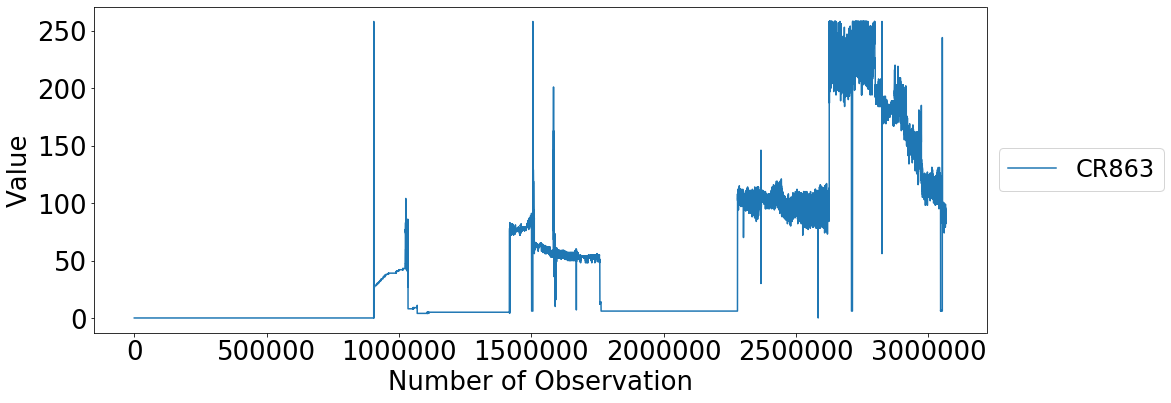

In [18]:
col = "CR863"
plot_dataset(test_df[[col]][:3066643])


In [19]:
len(test_df)

9199930

## Random Selection on real data

In [20]:
n_chunks = 50

In [21]:
sample_data = test_df[[col]][:3066643]
for i in range(1):
    sample_data = sample_data[[col]].append(sample_data[[col]], ignore_index=True)


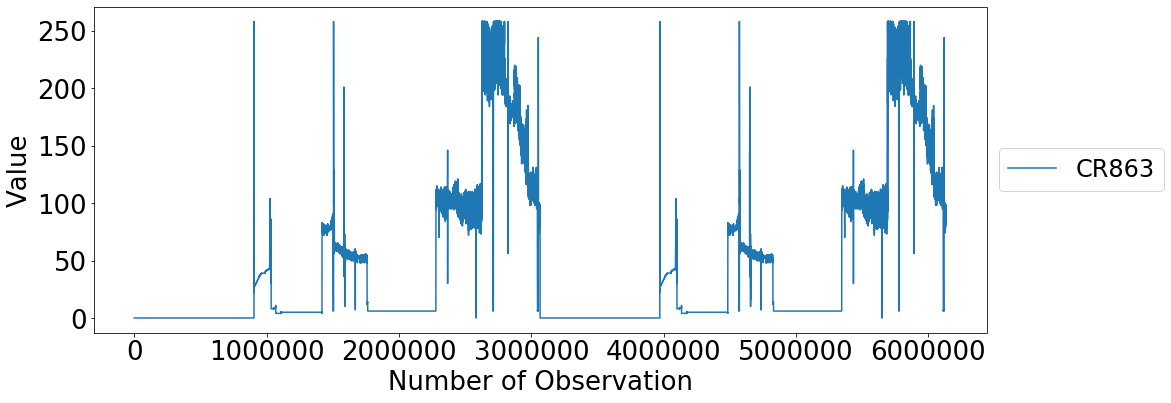

In [22]:
plot_dataset(sample_data)

In [23]:
for chunk in np.array_split(sample_data, n_chunks):
    print(len(chunk))
    break

122666


In [24]:
extended_data = pd.DataFrame()
for chunk in np.array_split(sample_data, n_chunks):
    extended_data = extended_data.append(chunk, ignore_index=True)
    extended_data = extended_data.append(chunk, ignore_index=True)
    extended_data = extended_data.append(chunk, ignore_index=True)
    extended_data = extended_data.append(chunk, ignore_index=True)
    extended_data = extended_data.append(chunk, ignore_index=True)
    extended_data = extended_data.append(chunk, ignore_index=True)
    extended_data = extended_data.append(chunk, ignore_index=True)
    extended_data = extended_data.append(chunk, ignore_index=True)
    extended_data = extended_data.append(chunk, ignore_index=True)
    extended_data = extended_data.append(chunk, ignore_index=True)
    extended_data = extended_data.append(chunk, ignore_index=True)
    extended_data = extended_data.append(chunk, ignore_index=True)
    extended_data = extended_data.append(chunk, ignore_index=True)
    extended_data = extended_data.append(chunk, ignore_index=True)
    extended_data = extended_data.append(chunk, ignore_index=True)
print(len(chunk))

122665


In [25]:
len(extended_data)

91999290

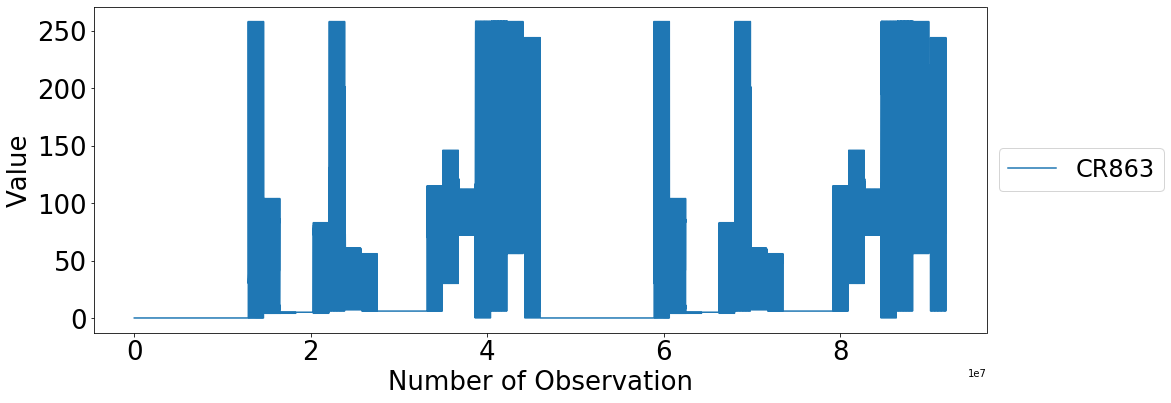

In [26]:
plot_dataset(extended_data)

In [27]:
#extended_data.to_csv("real_data_extended2.csv")

In [28]:
n_chunks = 2000

In [29]:
for chunk in np.array_split(extended_data, n_chunks):
    print(len(chunk))
    break

46000


Arm_counts {'quick_sort': 674, 'merge_sort': 684, 'heap_sort': 642}
Total reward -5.99730080000063


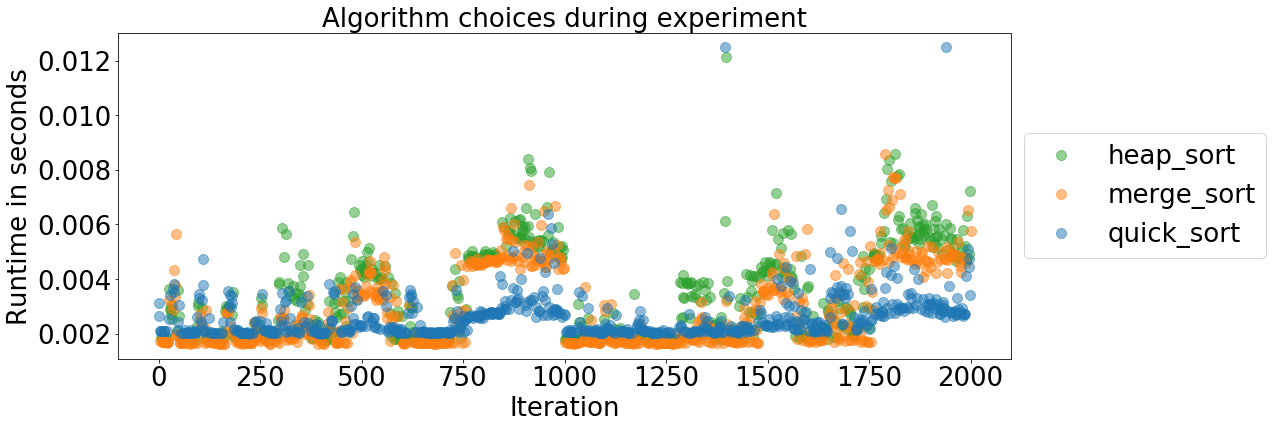

In [43]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history = random_selection(extended_data, n_chunks = n_chunks, col = col)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)

Arm_counts {'quick_sort': 645, 'merge_sort': 653, 'heap_sort': 702}
Total reward -5.844740000005004


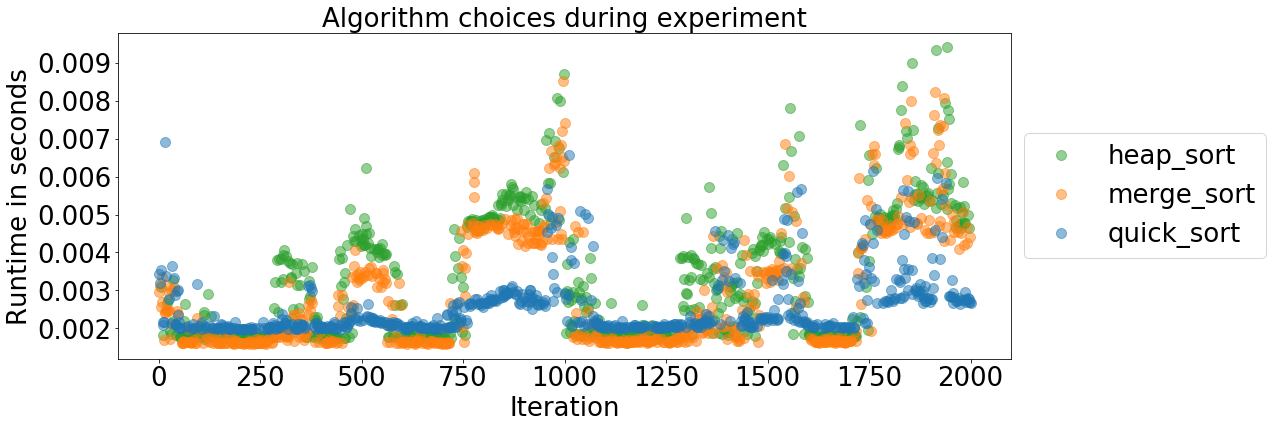

In [44]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history = random_selection(extended_data, n_chunks = n_chunks, col = col)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)

Arm_counts {'quick_sort': 698, 'merge_sort': 668, 'heap_sort': 634}
Total reward -5.506829199991898


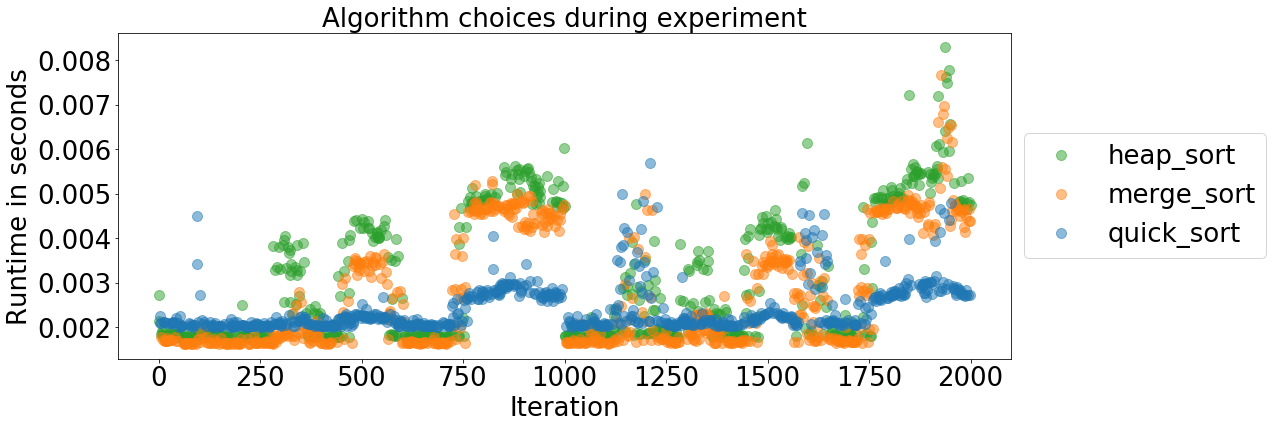

In [45]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history = random_selection(extended_data, n_chunks = n_chunks, col = col)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)

Arm_counts {'quick_sort': 663, 'merge_sort': 663, 'heap_sort': 674}
Total reward -5.406071599986717


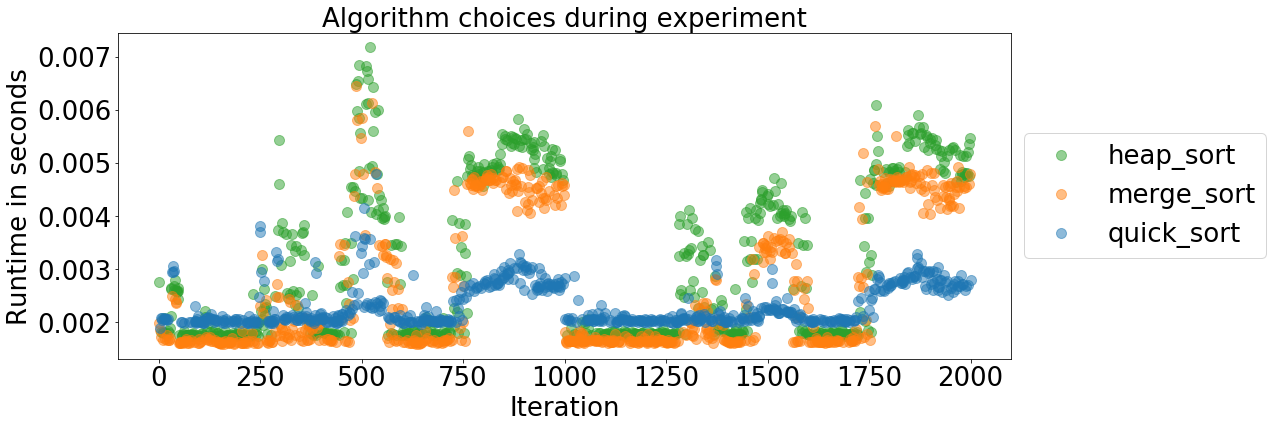

In [46]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history = random_selection(extended_data, n_chunks = n_chunks, col = col)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)

Arm_counts {'quick_sort': 2000, 'merge_sort': 0, 'heap_sort': 0}
Total reward -4.866339400002289


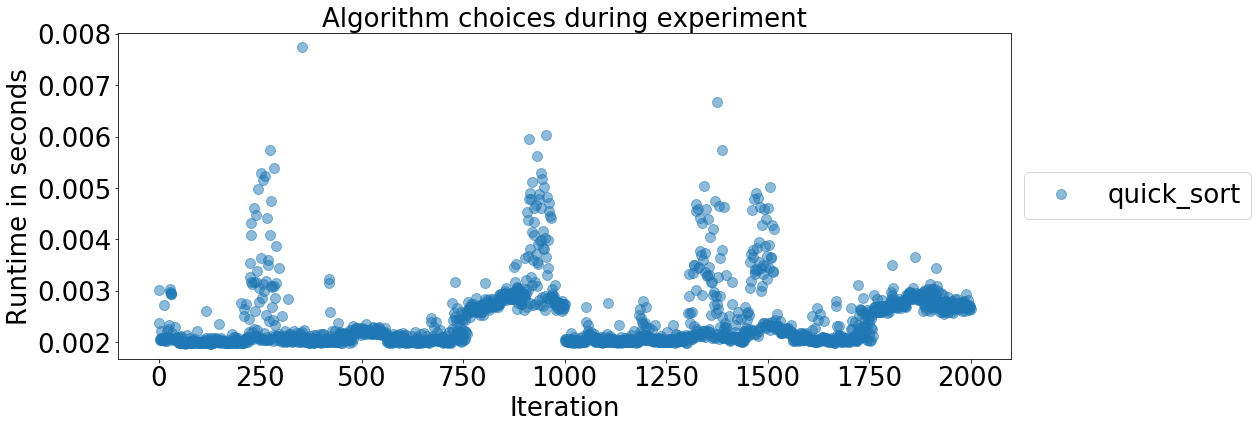

In [47]:
#quick sort 
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history = quick_sort_only(extended_data, n_chunks = n_chunks, col = col)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)

Arm_counts {'quick_sort': 0, 'merge_sort': 2000, 'heap_sort': 0}
Total reward -5.853889700003947


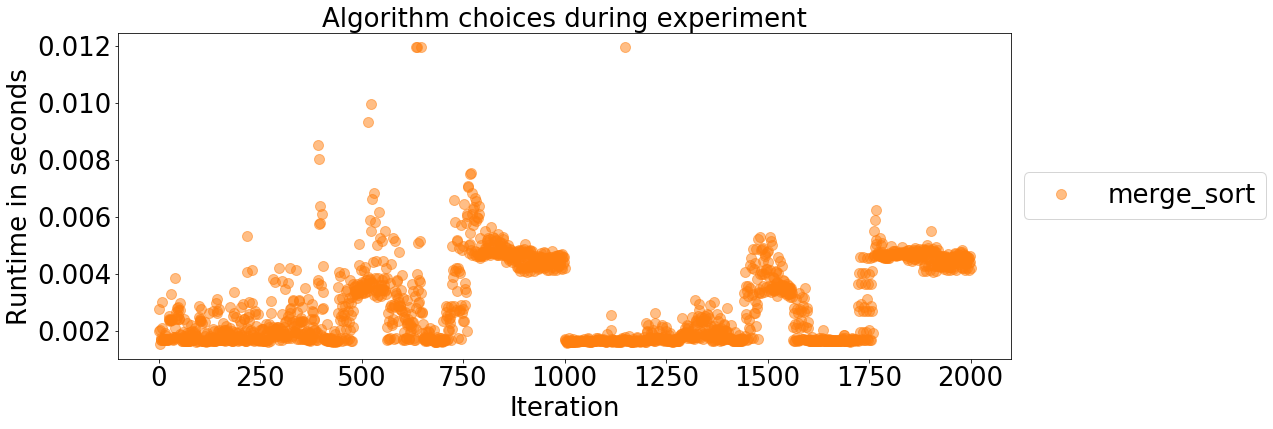

In [48]:
#merge sort 
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history = merge_sort_only(extended_data, n_chunks = n_chunks, col = col)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)

## UCB on real data

Arm_counts {'quick_sort': 958, 'merge_sort': 962, 'heap_sort': 80}
Total reward -4.727269900006377
Number of restarts 13 in iterations: [50, 283, 465, 562, 755, 842, 1002, 1244, 1261, 1315, 1365, 1400, 1410]


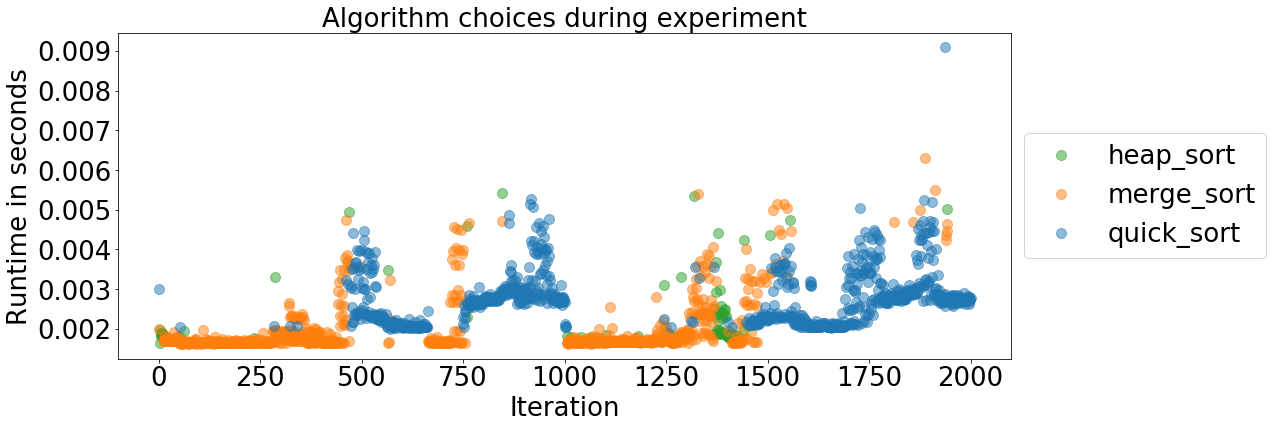

In [49]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(extended_data, n_chunks = n_chunks, col = col, bound_const=0.0001, quantile=0.025)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

Arm_counts {'quick_sort': 947, 'merge_sort': 831, 'heap_sort': 222}
Total reward -4.736055499997747
Number of restarts 11 in iterations: [202, 505, 564, 696, 1002, 1024, 1287, 1481, 1563, 1764, 1774]


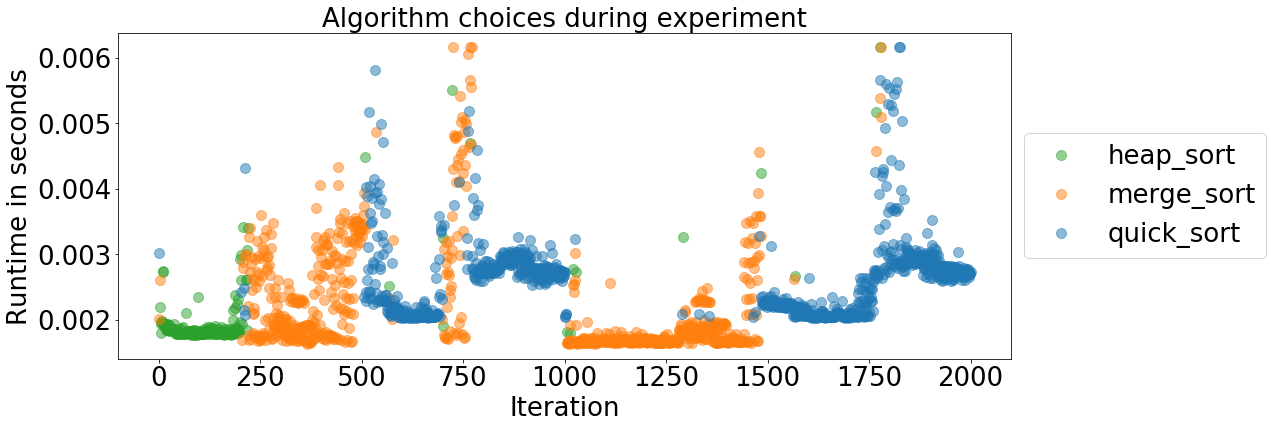

In [50]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(extended_data, n_chunks = n_chunks, col = col, bound_const=0.0001, quantile=0.025)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

Arm_counts {'quick_sort': 902, 'merge_sort': 776, 'heap_sort': 322}
Total reward -4.920787800004291
Number of restarts 10 in iterations: [168, 219, 260, 792, 1004, 1069, 1086, 1282, 1396, 1700]


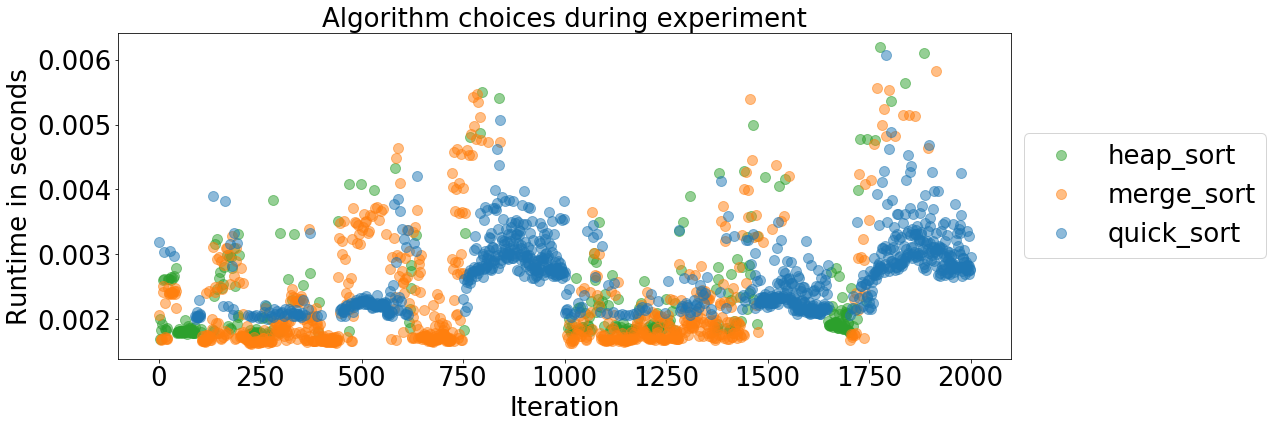

In [51]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(extended_data, n_chunks = n_chunks, col = col, bound_const=0.001, quantile=0.025)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

Arm_counts {'quick_sort': 755, 'merge_sort': 1025, 'heap_sort': 220}
Total reward -4.860962400005519
Number of restarts 12 in iterations: [297, 313, 430, 451, 787, 1002, 1077, 1115, 1209, 1442, 1525, 1761]


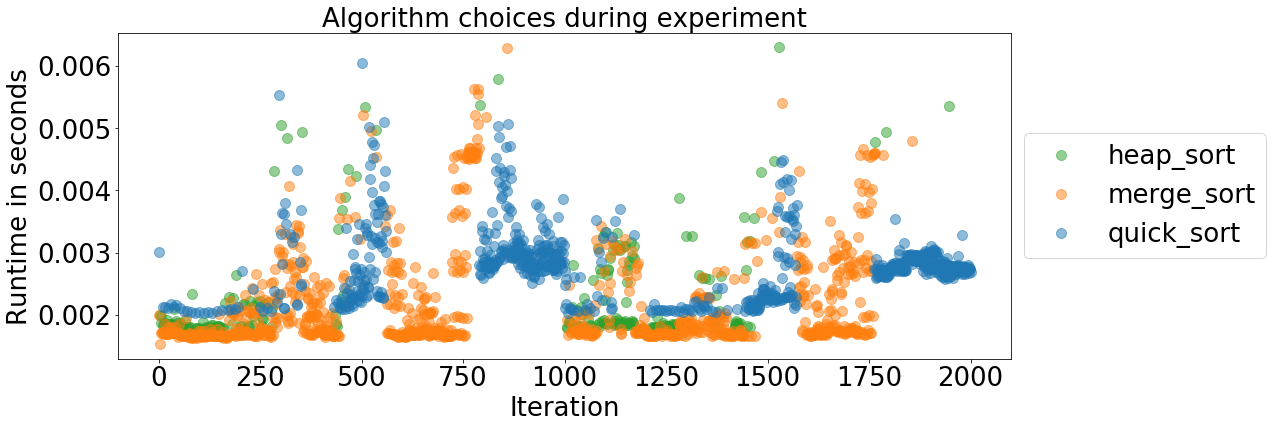

In [52]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(extended_data, n_chunks = n_chunks, col = col, bound_const=0.001, quantile=0.025)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

Arm_counts {'quick_sort': 417, 'merge_sort': 1554, 'heap_sort': 29}
Total reward -5.128640500005986
Number of restarts 4 in iterations: [497, 547, 562, 1878]


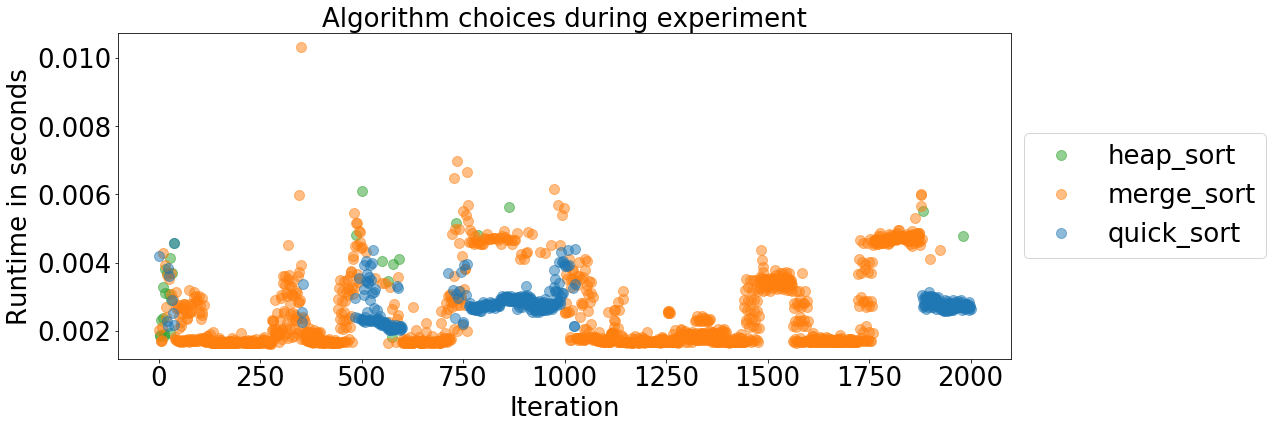

In [53]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(extended_data, n_chunks = n_chunks, col = col, bound_const=0.001, quantile=0.025)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

Arm_counts {'quick_sort': 893, 'merge_sort': 795, 'heap_sort': 312}
Total reward -4.993206500013457
Number of restarts 11 in iterations: [19, 54, 287, 828, 1002, 1039, 1074, 1303, 1601, 1767, 1977]


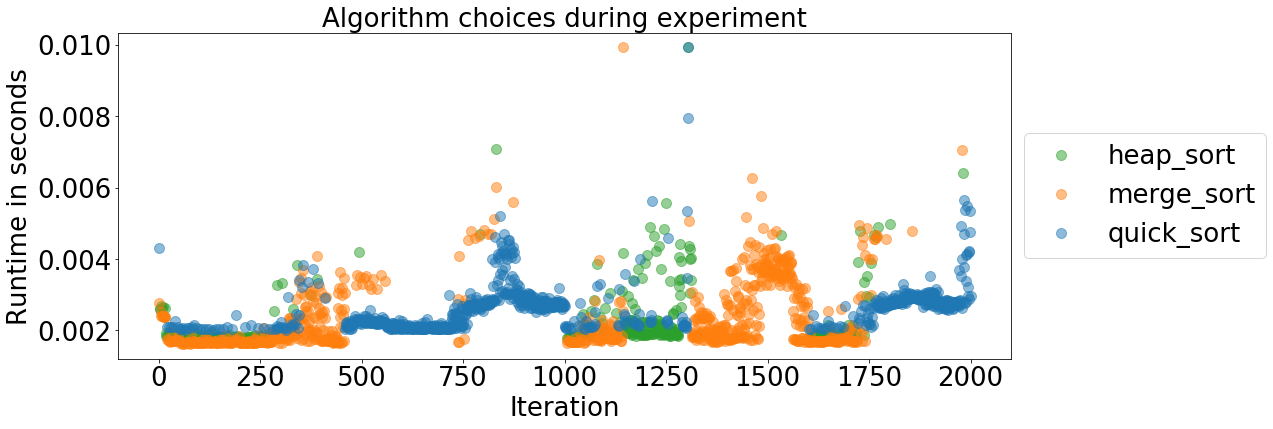

In [54]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(extended_data, n_chunks = n_chunks, col = col, bound_const=0.001, quantile=0.025)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

Arm_counts {'quick_sort': 809, 'merge_sort': 896, 'heap_sort': 295}
Total reward -4.524750400006724
Number of restarts 7 in iterations: [50, 485, 574, 761, 1002, 1333, 1761]


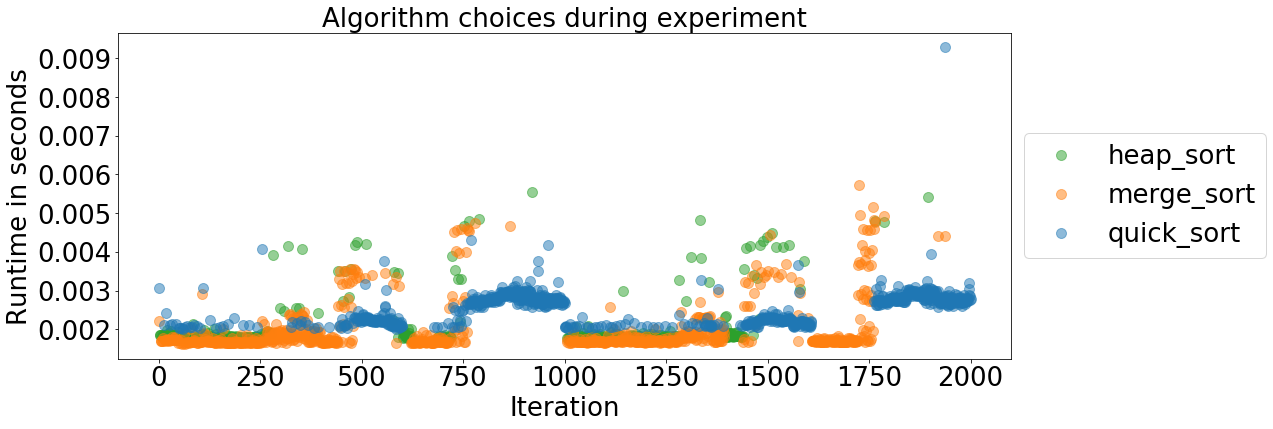

In [55]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(extended_data, n_chunks = n_chunks, col = col, bound_const=0.001, quantile=0.025)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)